In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from sklearn import linear_model
import pwlf

# Assumptions

In [3]:
DEATH_RATE = 0.01
ICU_RATE = 0.05
HOSPITAL_RATE = 0.15
SYMPTOM_RATE = 0.2
INFECT_2_HOSPITAL_TIME = 13
HOSPITAL_2_ICU_TIME = 2
ICU_2_DEATH_TIME = 5
ICU_2_RECOVER_TIME = 11
NOT_ICU_DISCHARGE_TIME = 7

In [4]:
avg_icu_time = int(np.round((ICU_2_DEATH_TIME*DEATH_RATE + ICU_2_RECOVER_TIME*(ICU_RATE-DEATH_RATE))/ICU_RATE, 0)) 
#(included both dead (5) and alive(11)): (5+11*4)/5
# Only ICU (critical) can develop death
avg_hospital_time = int(np.round(((HOSPITAL_2_ICU_TIME+ICU_2_DEATH_TIME)*DEATH_RATE+
                                  (HOSPITAL_2_ICU_TIME+ICU_2_RECOVER_TIME+NOT_ICU_DISCHARGE_TIME)*(ICU_RATE-DEATH_RATE)+
                                  NOT_ICU_DISCHARGE_TIME*(HOSPITAL_RATE-ICU_RATE))/HOSPITAL_RATE))
#Average hospital time is 10 (assume 7 days discharge if not in ICU or come back from ICU): ((2+5)+(2+11+7)*4)+7*10)/15

# Data

In [5]:
def get_global_death_data(csv_file='../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'):
    death_data = pd.read_csv(csv_file)
    return death_data.rename(index=str, columns={"Country/Region": "Country", "Province/State": "State"})

In [6]:
def get_US_death_data(csv_file='../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'):
    death_data = pd.read_csv(csv_file)
    return death_data.rename(index=str, columns={"Country_Region": "Country", 
                                                 "Province_State": "State", 
                                                 "Admin2": "County"})

In [7]:
def get_death_data_by_country(country):
    global_death_data = get_global_death_data()
    local_death_data = global_death_data.query('Country == "{}"'.format(country)).iloc[:,4:].T.sum(axis=1).to_frame()
    local_death_data.index = pd.to_datetime(local_death_data.index)
    return local_death_data[local_death_data>0].dropna()

In [8]:
def get_US_death_data_by_state(state):
    US_death_data = get_US_death_data()
    local_death_data = US_death_data.query('State == "{}"'.format(state)).iloc[:,12:].T.sum(axis=1).to_frame()
    local_death_data.index = pd.to_datetime(local_death_data.index)
    return local_death_data[local_death_data>0].dropna()

In [9]:
def get_US_death_data_by_county_and_state(county, state):
    US_death_data = get_US_death_data()
    local_death_data = US_death_data.query('County == "{}" and State == "{}"'.format(county, state)).iloc[:,12:].T.sum(axis=1).to_frame()
    local_death_data.index = pd.to_datetime(local_death_data.index)
    return local_death_data[local_death_data>0].dropna()

In [10]:
def get_daily_death(local_death_data):
    return local_death_data.diff().fillna(0)

#  Projection

In [11]:
def get_impute_from_death(death_row, periods, end_date_offset=0):
    date_ind = death_row.name
    end_date = date_ind + dt.timedelta(end_date_offset)
    date_range = pd.date_range(end=end_date, periods=periods)
    return pd.DataFrame(death_row.tolist()*periods, index=date_range)

In [12]:
def get_hospital_beds_from_death(death_row):
    '''Get imputation of hospital beds needed from one day record of new death'''
    dead_hospital_use_periods = HOSPITAL_2_ICU_TIME+ICU_2_DEATH_TIME
    dead_hospital_use = get_impute_from_death(death_row=death_row, 
                                              periods=dead_hospital_use_periods)
    ICU_recovered_hospital_use_periods = HOSPITAL_2_ICU_TIME+ICU_2_RECOVER_TIME+NOT_ICU_DISCHARGE_TIME
    ICU_recovered_hospital_use_end_date_offset = ICU_2_RECOVER_TIME-ICU_2_DEATH_TIME+NOT_ICU_DISCHARGE_TIME
    ICU_recovered_hospital_use = get_impute_from_death(death_row=death_row, 
                                                       periods=ICU_recovered_hospital_use_periods,
                                                       end_date_offset=ICU_recovered_hospital_use_end_date_offset)
    no_ICU_hospital_use_periods = NOT_ICU_DISCHARGE_TIME
    no_ICU_hospital_use_end_date_offset = -HOSPITAL_2_ICU_TIME-ICU_2_DEATH_TIME+NOT_ICU_DISCHARGE_TIME
    no_ICU_hospital_use = get_impute_from_death(death_row=death_row, 
                                                periods=no_ICU_hospital_use_periods,
                                                end_date_offset=no_ICU_hospital_use_end_date_offset)
    hospital_beds = dead_hospital_use.add(((ICU_RATE-DEATH_RATE)/DEATH_RATE)*ICU_recovered_hospital_use, fill_value=0)\
                                     .add(((HOSPITAL_RATE-ICU_RATE)/DEATH_RATE)*no_ICU_hospital_use, fill_value=0)
    hospital_beds.columns = ['hospital_beds']
    return hospital_beds

In [13]:
def get_ICU_from_death(death_row):
    '''Get imputation of ICU needed from one day record of new death'''
    dead_ICU_use = get_impute_from_death(death_row=death_row, periods=ICU_2_DEATH_TIME)
    recovered_ICU_use_end_date_offset = ICU_2_RECOVER_TIME-ICU_2_DEATH_TIME
    recovered_ICU_use = get_impute_from_death(death_row=death_row, 
                                              periods=ICU_2_RECOVER_TIME,
                                              end_date_offset=recovered_ICU_use_end_date_offset)
    ICU_n = dead_ICU_use.add(((ICU_RATE-DEATH_RATE)/DEATH_RATE)*recovered_ICU_use, fill_value=0)
    ICU_n.columns = ['ICU']
    return ICU_n

In [14]:
def get_infected_cases(local_death_data):
    '''This number only is close to number of confirmed case in country very early in the disease and 
    can still do contact tracing or very wide testing, eg. South Korea, Germany'''
    delay_time = INFECT_2_HOSPITAL_TIME + HOSPITAL_2_ICU_TIME + ICU_2_DEATH_TIME
    infected_cases = (1/DEATH_RATE)*local_death_data.tshift(-delay_time)
    infected_cases.columns = ['infected']
    return infected_cases

In [15]:
def get_symptomatic_cases(local_death_data):
    '''This is number of cases that show clear symptoms (severe),
    in country without investigative testing this is close to number of confirmed case, most country'''
    delay_time = HOSPITAL_2_ICU_TIME + ICU_2_DEATH_TIME
    symptomatic_cases = (SYMPTOM_RATE/DEATH_RATE)*local_death_data.tshift(-delay_time)
    symptomatic_cases.columns = ['symptomatic']
    return symptomatic_cases

In [16]:
def get_hospitalized_cases(local_death_data):
    '''In country with severe lack of testing, this is close to number of confirmed case, eg. Italy, Iran'''
    delay_time = HOSPITAL_2_ICU_TIME + ICU_2_DEATH_TIME
    hospitalized_cases = (HOSPITAL_RATE/DEATH_RATE)*local_death_data.tshift(-delay_time)
    hospitalized_cases.columns = ['hospitalized']
    return hospitalized_cases

In [17]:
def get_number_hospital_beds_need(daily_local_death_new):
    '''Calculate number of hospital bed needed from number of daily new death '''
    # Start by first date
    hospital_beds = get_hospital_beds_from_death(daily_local_death_new.iloc[0])
    # Run through all days
    for i in range(len(daily_local_death_new)-1):
        hospital_beds = hospital_beds.add(get_hospital_beds_from_death(daily_local_death_new.iloc[i+1]), 
                                          fill_value=0)
    return hospital_beds

In [18]:
def get_number_ICU_need(daily_local_death_new):
    '''Calculate number of ICU needed from number of daily new death '''
    # Start by first date
    ICU_n = get_ICU_from_death(daily_local_death_new.iloc[0])
    # Run through all days
    for i in range(len(daily_local_death_new)-1):
        ICU_n = ICU_n.add(get_ICU_from_death(daily_local_death_new.iloc[i+1]), fill_value=0)
    return ICU_n

In [19]:
def get_log_daily_predicted_death(local_death_data, forecast_horizon=60, lockdown_date=None):
    '''Since this is highly contagious disease. Daily new death, which is a proxy for daily new infected cases
    is model as d(t)=a*d(t-1) or equivalent to d(t) = b*a^(t). After a log transform, it becomes linear.
    log(d(t))=logb+t*loga, so we can use linear regression to provide forecast (use robust linear regressor to avoid
    data anomaly in death reporting)
    There are two seperate linear curves, one before the lockdown is effective(21 days after lockdown) and one after
    For using this prediction to infer back the other metrics (infected cases, hospital, ICU, etc..) only the before
    curve is used and valid. If we assume there is no new infection after lock down (perfect lockdown), the after
    curve only depends on the distribution of time to death since ICU.
    WARNING: if lockdown_date is not provided, we will default to no lockdown to raise awareness of worst case
    if no action. If you have info on lockdown date please use it to make sure the model provide accurate result'''
    daily_local_death_new = local_death_data.diff().fillna(0)
    daily_local_death_new.columns = ['death']
    log_daily_death = np.log(daily_local_death_new)
    #log_daily_death.dropna(inplace=True)
    data_start_date = min(local_death_data.index)
    data_end_date = max(local_death_data.index)
    forecast_end_date = data_end_date + dt.timedelta(forecast_horizon)
    forecast_date_index = pd.date_range(start=data_start_date, end=forecast_end_date)
    if lockdown_date is not None:
        lockdown_date = pd.to_datetime(lockdown_date)
    else:
        lockdown_date = forecast_end_date
    lockdown_effective_date = lockdown_date + dt.timedelta(INFECT_2_HOSPITAL_TIME+HOSPITAL_2_ICU_TIME+ICU_2_DEATH_TIME)
    data_start_date_idx = (data_start_date - lockdown_effective_date).days
    data_end_date_idx = (data_end_date - lockdown_effective_date).days
    forecast_end_date_idx = data_end_date_idx + forecast_horizon
    forecast_time_idx = (forecast_date_index - lockdown_effective_date).days.values
    data_time_idx = (log_daily_death.index - lockdown_effective_date).days.values
    log_daily_death['time_idx'] = data_time_idx
    log_daily_death = log_daily_death.replace([np.inf, -np.inf], np.nan).dropna()
    log_daily_death_before = log_daily_death[log_daily_death.time_idx<0]
    regr_before = linear_model.HuberRegressor(fit_intercept=True)
    regr_before.fit(log_daily_death_before.time_idx.values.reshape(-1, 1), log_daily_death_before.death)
    log_predicted_death_before_values = regr_before.predict(forecast_time_idx[forecast_time_idx<0].reshape(-1, 1))
    log_predicted_death_before_index = forecast_date_index[forecast_time_idx<0]
    log_predicted_death_before = pd.DataFrame(log_predicted_death_before_values, 
                                              index=log_predicted_death_before_index)
    if all(forecast_time_idx<0):
        print("Lockdown is not effective in forecast range. Second model not needed")
        log_predicted_death_after = None
    elif all(data_time_idx<=1):
        print("Use default second model due to no data")
        regr_after = linear_model.HuberRegressor(fit_intercept=True)
        regr_after.coef_ = np.array([-0.04])
        regr_after.intercept_ = log_predicted_death_before.iloc[-1,0]           
        log_predicted_death_after_values = regr_after.predict(forecast_time_idx[forecast_time_idx>=0].reshape(-1, 1))
        log_predicted_death_after_index = forecast_date_index[forecast_time_idx>=0]
        log_predicted_death_after = pd.DataFrame(log_predicted_death_after_values, 
                                                  index=log_predicted_death_after_index)
        log_predicted_death = pd.concat([log_predicted_death_before, log_predicted_death_after], axis=0)
    else:
        regr_pw = pwlf.PiecewiseLinFit(x=log_daily_death.time_idx.values, y=log_daily_death.death)
        break_points = np.array([data_start_date_idx, 0, data_end_date_idx])
        regr_pw.fit_with_breaks(break_points)
        log_predicted_death_values = regr_pw.predict(forecast_time_idx)
        log_predicted_death = pd.DataFrame(log_predicted_death_values, index=forecast_date_index)
    
    log_predicted_death.columns = ['predicted_death']
    return log_predicted_death

In [20]:
def get_daily_predicted_death(local_death_data, forecast_horizon=60, lockdown_date=None):
    return np.exp(get_log_daily_predicted_death(local_death_data, forecast_horizon, lockdown_date)).astype(int)

In [21]:
def get_cummulative_predicted_death(local_death_data, forecast_horizon=60, lockdown_date=None):
    daily_predicted_death = get_daily_predicted_death(local_death_data, forecast_horizon, lockdown_date)
    return daily_predicted_death.cumsum()

# Output

In [22]:
def get_daily_metrics_from_death_data(local_death_data, forecast_horizon=60, lockdown_date=None):
    daily_predicted_death = get_daily_predicted_death(local_death_data, forecast_horizon, lockdown_date)
    daily_local_death_new = local_death_data.diff().fillna(0)
    daily_local_death_new.columns = ['death']
    daily_infected_cases_new = get_infected_cases(daily_predicted_death)
    daily_symptomatic_cases_new = get_symptomatic_cases(daily_predicted_death)
    daily_hospitalized_cases_new = get_hospitalized_cases(daily_predicted_death)
    daily_hospital_beds_need = get_number_hospital_beds_need(daily_predicted_death)
    daily_ICU_need = get_number_ICU_need(daily_predicted_death)
    return pd.concat([daily_local_death_new,
                      daily_predicted_death,
                      daily_infected_cases_new,
                      daily_symptomatic_cases_new,
                      daily_hospitalized_cases_new,
                      daily_hospital_beds_need, 
                      daily_ICU_need], axis=1, sort=True)

In [23]:
def get_cummulative_metrics_from_death_data(local_death_data, forecast_horizon=60, lockdown_date=None):
    daily_metrics = get_daily_metrics_from_death_data(local_death_data, forecast_horizon, lockdown_date)
    cummulative_metrics = daily_metrics.cumsum()
    cummulative_metrics['ICU'] = daily_metrics['ICU']
    cummulative_metrics['hospital_beds'] = daily_metrics['hospital_beds']
    return cummulative_metrics

In [24]:
def get_metrics_by_country(country, forecast_horizon=60, lockdown_date=None):
    local_death_data = get_death_data_by_country(country)
    daily_metrics = get_daily_metrics_from_death_data(local_death_data, forecast_horizon, lockdown_date)
    cummulative_metrics = get_cummulative_metrics_from_death_data(local_death_data, forecast_horizon, lockdown_date)
    return daily_metrics, cummulative_metrics

In [25]:
def get_metrics_by_state_US(state, forecast_horizon=60, lockdown_date=None):
    local_death_data = get_US_death_data_by_state(state)
    daily_metrics = get_daily_metrics_from_death_data(local_death_data, forecast_horizon, lockdown_date)
    cummulative_metrics = get_cummulative_metrics_from_death_data(local_death_data, forecast_horizon, lockdown_date)
    return daily_metrics, cummulative_metrics

In [26]:
def get_metrics_by_county_and_state_US(county, state, forecast_horizon=60, lockdown_date=None):
    local_death_data = get_US_death_data_by_county_and_state(county, state)
    daily_metrics = get_daily_metrics_from_death_data(local_death_data, forecast_horizon, lockdown_date)
    cummulative_metrics = get_cummulative_metrics_from_death_data(local_death_data, forecast_horizon, lockdown_date)
    return daily_metrics, cummulative_metrics

In [33]:
plot_metrics_by_state_US('California', lockdown_date='20200319')

/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  


ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
plot_metrics_by_state_US('California', lockdown_date='20200319', metrics = ['death', 'predicted_death'])

In [ ]:
ny_daily, ny_cum = get_metrics_by_state_US('New York', lockdown_date='20200319')

In [ ]:
ny_cum.iloc[10:50]

In [ ]:
ny_daily.iloc[30:50]

In [ ]:
plot_metrics_by_state_US('New York', lockdown_date='20200319', metrics = ['death', 'predicted_death'])

In [ ]:
plot_metrics_by_country('China', lockdown_date='20200123')

In [ ]:
plot_metrics_by_country('China', lockdown_date='20200123',
                             metrics = ['death', 'predicted_death', 'symptomatic', 'hospitalized', 'ICU', 'hospital_beds'])

In [ ]:
plot_metrics_by_country('China', lockdown_date='20200123',
                             metrics = ['death', 'predicted_death'])

In [ ]:
plot_metrics_by_country('US', lockdown_date='20200318',
                             metrics = ['death', 'predicted_death', 'symptomatic', 'hospitalized', 'ICU', 'hospital_beds'])

In [ ]:
plot_metrics_by_country('US', lockdown_date='20200318',
                             metrics = ['predicted_death', 'ICU'])

In [ ]:
plot_metrics_by_country('US', lockdown_date='20200318',
                             metrics = ['death', 'predicted_death'])

In [ ]:
plot_metrics_by_country('Italy', lockdown_date='20200301', forecast_horizon=90) #Official date 09 March

In [ ]:
plot_metrics_by_country('Spain', lockdown_date='20200305') #official date 14 March

In [ ]:
plot_metrics_by_country('France', lockdown_date='20200331')

In [ ]:
plot_metrics_by_country('Germany', lockdown_date='20200322', metrics=['death', 'predicted_death'])

In [ ]:
plot_metrics_by_country('United Kingdom', lockdown_date='20200323', metrics=['death', 'predicted_death'])

# The tails of two curves 21 days after lockdown

In [ ]:
plot_log_death_new_by_country('Iran', lockdown_date='20200227') #Official date unclear

In [ ]:
plot_log_death_new_by_country('China',  lockdown_date='20200124')

TODO: add function get county and provided all number
        improve the curve for after period

In [ ]:
death_data = get_global_death_data()

In [ ]:
death_data.query('Country=="US"')

In [ ]:
len(death_data.Country.unique())

In [ ]:
death_data.

In [ ]:
death_data.Country.unique()[156
                           ]

In [ ]:
death_data = get_US_death_data()

In [ ]:
death_data.State.unique()

In [ ]:
def get_lockdown_date_state_US(csv_file='data/lockdown_date_state_US.csv'):
    return pd.read_csv(csv_file)[['state', 'lockdown_date']].set_index('state')

In [ ]:
lockdown_date_state_US = get_lockdown_date_state_US()

In [ ]:
lockdown_date_state_US.loc['California'][0]

In [ ]:
pd.to_datetime(lockdown_date_state_US.loc['California'][0])

In [ ]:
getattr(lockdown_date_state_US, 'Alaska')

In [ ]:
import model_utils

In [ ]:
import pandas as pd
import datetime as dt
def put_model_params_logs(model_params, file='model_params_logs.csv'):
    pd.DataFrame(model_params, index=[dt.datetime.today()]).to_csv(file, mode='a', header=False)
from csv import writer
def append_model_params_2_logs(model_params, log_file='model_params_logs.csv'):
    # Open file in append mode
    with open(log_file, 'a+', newline='') as write_obj:
        # Create a writer object from csv module
        csv_writer = writer(write_obj)
        # Add contents of list as last row in the csv file
        csv_writer.writerow(model_params)

In [ ]:
scope = 'country'
local = 'US'
lockdown_date = '20200320'
model_params =(scope, local, lockdown_date)
append_model_params_2_logs(model_params, file_name='model_params_logs.csv')

In [ ]:
[dt.datetime.today(),]+[3,3,3]

In [ ]:
model_params = [dt.datetime.today(), scope, local, lockdown_date, 
                mu.DEATH_RATE,
                mu.ICU_RATE,
                mu.HOSPITAL_RATE, 
                mu.SYMPTOM_RATE, 
                mu.INFECT_2_HOSPITAL_TIME, 
                mu.HOSPITAL_2_ICU_TIME, 
                mu.ICU_2_DEATH_TIME, 
                mu.ICU_2_RECOVER_TIME,
                mu.NOT_ICU_DISCHARGE_TIME]
append_model_params_2_logs(model_params)

In [ ]:
import pandas as pd

In [ ]:
logs = pd.DataFrame.from_csv('model_params_logs.csv')

In [ ]:
logs

In [ ]:
import streamlit as st
import os
os.path.dirname(st.__file__)

In [ ]:
dir(st)

In [34]:
import model_utils as mu


InternalHashError: module '__main__' has no attribute '__file__'

While caching the body of `get_global_death_data()`, Streamlit encountered an
object of type `builtins.function`, which it does not know how to hash.

**In this specific case, it's very likely you found a Streamlit bug so please
[file a bug report here.]
(https://github.com/streamlit/streamlit/issues/new/choose)**

In the meantime, you can try bypassing this error by registering a custom
hash function via the `hash_funcs` keyword in @st.cache(). For example:

```
@st.cache(hash_funcs={builtins.function: my_hash_func})
def my_func(...):
    ...
```

If you don't know where the object of type `builtins.function` is coming
from, try looking at the hash chain below for an object that you do recognize,
then pass that to `hash_funcs` instead:

```
Object of type builtins.function: <function get_global_death_data at 0x10969e510>
Object of type builtins.tuple: ('model_utils', 'get_global_death_data', <function get_global_death_data at 0x10969e510>)
```

Please see the `hash_funcs` [documentation]
(https://streamlit.io/docs/advanced_caching.html)
for more details.
            

In [39]:
local_death_data = get_death_data_by_country('China')

In [40]:
local_death_data

,0
2020-01-22,17
2020-01-23,18
2020-01-24,26
2020-01-25,42
2020-01-26,56
2020-01-27,82
2020-01-28,131
2020-01-29,133
2020-01-30,171
2020-01-31,213


In [41]:
daily_local_death_new = local_death_data.diff().fillna(0)
daily_local_death_new.columns = ['death']
log_daily_death = np.log(daily_local_death_new)

/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [42]:
log_daily_death

,death
2020-01-22,-inf
2020-01-23,0.000000
2020-01-24,2.079442
2020-01-25,2.772589
2020-01-26,2.639057
2020-01-27,3.258097
2020-01-28,3.891820
2020-01-29,0.693147
2020-01-30,3.637586
2020-01-31,3.737670


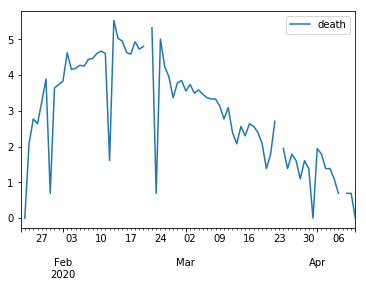

In [43]:
log_daily_death.plot()

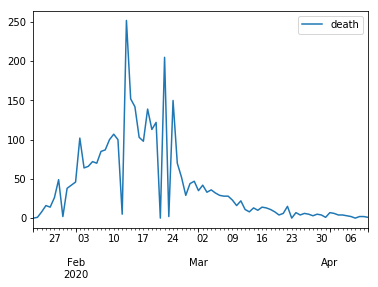

In [45]:
daily_local_death_new.plot()

In [47]:
daily_local_death_new.head(60)

,death
2020-01-22,0.0
2020-01-23,1.0
2020-01-24,8.0
2020-01-25,16.0
2020-01-26,14.0
2020-01-27,26.0
2020-01-28,49.0
2020-01-29,2.0
2020-01-30,38.0
2020-01-31,42.0


In [48]:
type(daily_local_death_new)

pandas.core.frame.DataFrame

In [96]:
def get_log_daily_predicted_death(local_death_data, forecast_horizon=60, lockdown_date=None):
    '''Since this is highly contagious disease. Daily new death, which is a proxy for daily new infected cases
    is model as d(t)=a*d(t-1) or equivalent to d(t) = b*a^(t). After a log transform, it becomes linear.
    log(d(t))=logb+t*loga, so we can use linear regression to provide forecast (use robust linear regressor to avoid
    data anomaly in death reporting)
    There are two seperate linear curves, one before the lockdown is effective(21 days after lockdown) and one after
    For using this prediction to infer back the other metrics (infected cases, hospital, ICU, etc..) only the before
    curve is used and valid. If we assume there is no new infection after lock down (perfect lockdown), the after
    curve only depends on the distribution of time to death since ICU.
    WARNING: if lockdown_date is not provided, we will default to no lockdown to raise awareness of worst case
    if no action. If you have info on lockdown date please use it to make sure the model provide accurate result'''
    daily_local_death_new = local_death_data.diff().fillna(0)
    daily_local_death_new.columns = ['death']
    log_daily_death = np.log(daily_local_death_new)
    # log_daily_death.dropna(inplace=True)
    data_start_date = min(local_death_data.index)
    data_end_date = max(local_death_data.index)
    forecast_end_date = data_end_date + dt.timedelta(forecast_horizon)
    forecast_date_index = pd.date_range(start=data_start_date, end=forecast_end_date)
    if lockdown_date is not None:
        lockdown_date = pd.to_datetime(lockdown_date)
    else:
        lockdown_date = forecast_end_date
    lockdown_effective_date = lockdown_date + dt.timedelta(
        INFECT_2_HOSPITAL_TIME + HOSPITAL_2_ICU_TIME + ICU_2_DEATH_TIME)
    data_start_date_idx = (data_start_date - lockdown_effective_date).days
    data_end_date_idx = (data_end_date - lockdown_effective_date).days
    forecast_end_date_idx = data_end_date_idx + forecast_horizon
    forecast_time_idx = (forecast_date_index - lockdown_effective_date).days.values
    data_time_idx = (log_daily_death.index - lockdown_effective_date).days.values
    log_daily_death['time_idx'] = data_time_idx
    log_daily_death = log_daily_death.replace([np.inf, -np.inf], np.nan).dropna()
    log_daily_death_before = log_daily_death[log_daily_death.time_idx < 0]
    regr_before = linear_model.HuberRegressor(fit_intercept=True)
    regr_before.fit(log_daily_death_before.time_idx.values.reshape(-1, 1), log_daily_death_before.death)
    log_predicted_death_before_values = regr_before.predict(forecast_time_idx[forecast_time_idx < 0].reshape(-1, 1))
    log_predicted_death_before_index = forecast_date_index[forecast_time_idx < 0]
    log_predicted_death_before = pd.DataFrame(log_predicted_death_before_values,
                                              index=log_predicted_death_before_index)
    if all(forecast_time_idx < 0):
        print("Lockdown is not effective in forecast range. Second model not needed")
        log_predicted_death_after = None
    elif all(data_time_idx <= 1):
        print("Use default second model due to no data")
        regr_after = linear_model.HuberRegressor(fit_intercept=True)
        regr_after.coef_ = np.array([-0.04])
        regr_after.intercept_ = log_predicted_death_before.iloc[-1, 0]
        log_predicted_death_after_values = regr_after.predict(forecast_time_idx[forecast_time_idx >= 0].reshape(-1, 1))
        log_predicted_death_after_index = forecast_date_index[forecast_time_idx >= 0]
        log_predicted_death_after = pd.DataFrame(log_predicted_death_after_values,
                                                 index=log_predicted_death_after_index)
        log_predicted_death = pd.concat([log_predicted_death_before, log_predicted_death_after], axis=0)
    else:
        regr_pw = pwlf.PiecewiseLinFit(x=log_daily_death.time_idx.values, y=log_daily_death.death)
        break_points = np.array([data_start_date_idx, 0, data_end_date_idx])
        regr_pw.fit_with_breaks(break_points)
        log_predicted_death_train = regr_pw.predict(log_daily_death.time_idx.values)
        #Remove outliers that is in the 0.001 tail (mostly due to death reporting delay)
        log_predicted_death_train_pred_var = regr_pw.prediction_variance(log_daily_death.time_idx.values)
        log_predicted_death_train_lower_bound = log_predicted_death_train-3.29*np.sqrt(log_predicted_death_train_pred_var)
        log_predicted_death_train_upper_bound = log_predicted_death_train+3.29*np.sqrt(log_predicted_death_train_pred_var)
        
        #import pdb; pdb.set_trace()
        log_predicted_death_values = regr_pw.predict(forecast_time_idx)
        log_predicted_death = pd.DataFrame(log_predicted_death_values, index=forecast_date_index)

    log_predicted_death.columns = ['predicted_death']
    return log_predicted_death, log_predicted_death_train,\
            log_predicted_death_train_lower_bound, log_predicted_death_train_upper_bound


In [97]:
log_predicted, train, lb, ub = get_log_daily_predicted_death(local_death_data, forecast_horizon=60, lockdown_date='20200123')

/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


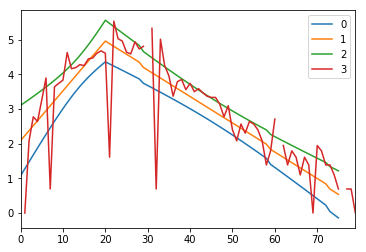

In [98]:
pd.DataFrame([lb, train, ub, log_daily_death.death]).T.plot()

In [91]:
pd.DataFrame([lb, train, ub, log_daily_death.death]).T.head()

,0,1,2,3
0,1.483780,2.087937,2.692095,-inf
1,1.662039,2.231357,2.800675,0.000000
2,1.839712,2.374776,2.909840,2.079442
3,2.016680,2.518195,3.019710,2.772589
4,2.192791,2.661614,3.130437,2.639057


In [ ]:
def fix_delay_death_report():
    '''The pattern we try to address is the death number in one day is significantly lower,
    and then it is accumulated to a much higher death number for the next day, the day after that 
    we see the death number come back to normal'''

In [99]:
forecast_horizon=60
lockdown_date='20200123'

In [100]:
daily_local_death_new = local_death_data.diff().fillna(0)
daily_local_death_new.columns = ['death']
log_daily_death = np.log(daily_local_death_new)
# log_daily_death.dropna(inplace=True)
data_start_date = min(local_death_data.index)
data_end_date = max(local_death_data.index)
forecast_end_date = data_end_date + dt.timedelta(forecast_horizon)
forecast_date_index = pd.date_range(start=data_start_date, end=forecast_end_date)
if lockdown_date is not None:
    lockdown_date = pd.to_datetime(lockdown_date)
else:
    lockdown_date = forecast_end_date
lockdown_effective_date = lockdown_date + dt.timedelta(
    INFECT_2_HOSPITAL_TIME + HOSPITAL_2_ICU_TIME + ICU_2_DEATH_TIME)
data_start_date_idx = (data_start_date - lockdown_effective_date).days
data_end_date_idx = (data_end_date - lockdown_effective_date).days
forecast_end_date_idx = data_end_date_idx + forecast_horizon
forecast_time_idx = (forecast_date_index - lockdown_effective_date).days.values
data_time_idx = (log_daily_death.index - lockdown_effective_date).days.values
log_daily_death['time_idx'] = data_time_idx
log_daily_death = log_daily_death.replace([np.inf, -np.inf], np.nan).dropna()
log_daily_death_before = log_daily_death[log_daily_death.time_idx < 0]
regr_before = linear_model.HuberRegressor(fit_intercept=True)
regr_before.fit(log_daily_death_before.time_idx.values.reshape(-1, 1), log_daily_death_before.death)
log_predicted_death_before_values = regr_before.predict(forecast_time_idx[forecast_time_idx < 0].reshape(-1, 1))
log_predicted_death_before_index = forecast_date_index[forecast_time_idx < 0]
log_predicted_death_before = pd.DataFrame(log_predicted_death_before_values,
                                          index=log_predicted_death_before_index)
if all(forecast_time_idx < 0):
    print("Lockdown is not effective in forecast range. Second model not needed")
    log_predicted_death_after = None
elif all(data_time_idx <= 1):
    print("Use default second model due to no data")
    regr_after = linear_model.HuberRegressor(fit_intercept=True)
    regr_after.coef_ = np.array([-0.04])
    regr_after.intercept_ = log_predicted_death_before.iloc[-1, 0]
    log_predicted_death_after_values = regr_after.predict(forecast_time_idx[forecast_time_idx >= 0].reshape(-1, 1))
    log_predicted_death_after_index = forecast_date_index[forecast_time_idx >= 0]
    log_predicted_death_after = pd.DataFrame(log_predicted_death_after_values,
                                             index=log_predicted_death_after_index)
    log_predicted_death = pd.concat([log_predicted_death_before, log_predicted_death_after], axis=0)
else:
    regr_pw = pwlf.PiecewiseLinFit(x=log_daily_death.time_idx.values, y=log_daily_death.death)
    break_points = np.array([data_start_date_idx, 0, data_end_date_idx])
    regr_pw.fit_with_breaks(break_points)
    log_predicted_death_train = regr_pw.predict(log_daily_death.time_idx.values)
    #Remove outliers that is in the 0.001 tail (mostly due to death reporting delay)
    log_predicted_death_train_pred_var = regr_pw.prediction_variance(log_daily_death.time_idx.values)
    log_predicted_death_train_lower_bound = log_predicted_death_train-3.29*np.sqrt(log_predicted_death_train_pred_var)
    log_predicted_death_train_upper_bound = log_predicted_death_train+3.29*np.sqrt(log_predicted_death_train_pred_var)

    #import pdb; pdb.set_trace()
    log_predicted_death_values = regr_pw.predict(forecast_time_idx)
    log_predicted_death = pd.DataFrame(log_predicted_death_values, index=forecast_date_index)

log_predicted_death.columns = ['predicted_death']



/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [101]:
log_daily_death.where('(log_daily_death.death-log_predicted_death_train)<3.29*np.sqrt(log_predicted_death_train_pred_var)')

ValueError: Array conditional must be same shape as self

In [113]:
cond = abs(log_daily_death.death-log_predicted_death_train)<3.29*np.sqrt(log_predicted_death_train_pred_var)

In [103]:
cond.shape

(76,)

In [114]:
log_daily_death_wo_outlier = log_daily_death[cond]
log_daily_death_wo_outlier

,death,time_idx
2020-01-24,2.079442,-19
2020-01-25,2.772589,-18
2020-01-26,2.639057,-17
2020-01-27,3.258097,-16
2020-01-30,3.637586,-13
2020-01-31,3.737670,-12
2020-02-01,3.828641,-11
2020-02-04,4.189655,-8
2020-02-05,4.276666,-7
2020-02-06,4.248495,-6


In [ ]:
regr_pw_wo_outlier = pwlf.PiecewiseLinFit(x=log_daily_death.time_idx.values, y=log_daily_death.death)
break_points = np.array([data_start_date_idx, 0, data_end_date_idx])
regr_pw.fit_with_breaks(break_points)

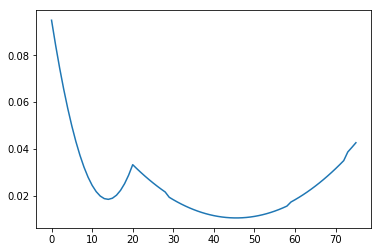

In [53]:
import matplotlib.pyplot as plt
plt.plot(np.array([0.09501409, 0.08437188, 0.07452454, 0.06547205, 0.05721442,
       0.04975166, 0.04308375, 0.0372107 , 0.03213251, 0.02784919,
       0.02436072, 0.02166711, 0.01976836, 0.01866447, 0.01835545,
       0.01884128, 0.02012197, 0.02219752, 0.02506793, 0.0287332 ,
       0.03319333, 0.03150572, 0.02988301, 0.0283252 , 0.02683229,
       0.02540428, 0.02404117, 0.02274296, 0.02150964, 0.01923772,
       0.01819911, 0.0172254 , 0.01631659, 0.01547268, 0.01469367,
       0.01397956, 0.01333035, 0.01274604, 0.01222663, 0.01177212,
       0.01138251, 0.0110578 , 0.010798  , 0.01060309, 0.01047308,
       0.01040797, 0.01040776, 0.01047245, 0.01060204, 0.01079653,
       0.01105593, 0.01138022, 0.01176941, 0.0122235 , 0.01274249,
       0.01332638, 0.01397518, 0.01468887, 0.01546746, 0.01721935,
       0.01819264, 0.01923083, 0.02033392, 0.02150192, 0.02273481,
       0.0240326 , 0.0253953 , 0.02682289, 0.02831538, 0.02987278,
       0.03149507, 0.03318226, 0.03493436, 0.03863325, 0.04058004,
       0.04259173]))

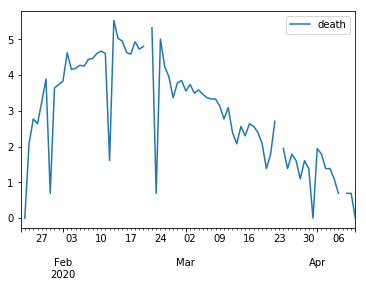

In [54]:
log_daily_death.plot()

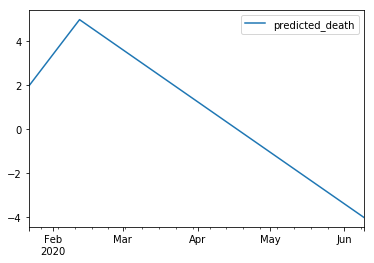

In [57]:
log_predicted.plot()

In [59]:
log_predicted.columns = ['death']


In [60]:
log_daily_death-log_predicted

,death
2020-01-22,-inf
2020-01-23,-2.087937
2020-01-24,-0.151915
2020-01-25,0.397813
2020-01-26,0.120862
2020-01-27,0.596482
2020-01-28,1.086787
2020-01-29,-2.255305
2020-01-30,0.545715
2020-01-31,0.502379
